In [76]:
import matplotlib.pyplot as plt
import numpy as np
from load_data import (
    MOVIE_LEN, FRAME_SHAPE, 
    load_movie, load_ground_truth_generation_data
)
from unet_basic.model_3d import unet3d, unet3d_simply, plot_model
import unet_basic
import tensorflow as tf
import data_gen
from importlib import reload
from skimage.io import imshow, imsave
from skimage.measure import label
from scipy.ndimage.morphology import distance_transform_edt
import skimage
reload(data_gen)

DataSequencer = data_gen.DataSequencer
get_indices_split = data_gen.get_indices_split

DATA_PACKED_FOR_GT_GENERATION_PATH = "../dataPackedForGeneration.mat"
MOVIE_PATH = "../preprocessed/preprocessedMovie.h5"
FRAMES_TO_LOAD = 1000

In [77]:
movie = load_movie(MOVIE_PATH)
movie = np.array(movie[:FRAMES_TO_LOAD])
print(movie.shape)

data_packed = \
    load_ground_truth_generation_data(DATA_PACKED_FOR_GT_GENERATION_PATH)

(1000, 500, 500)


In [ ]:
indices_all = np.array(range(4,FRAMES_TO_LOAD-4))
indices_train, indices_validate, indices_test = \
    get_indices_split(indices_all, data_fraction=1)

# Parameters
spatial_dims = {
    '128': (128, 128),
    '256': (256, 256)}

params = {'spatial_dim': spatial_dims['128'],
          'temporal_dim': 8,
          'batch_size': 4,
          'shuffle': True, 
          'positive_label_weight': 50, 
          'use_sample_weights': False}

# Generators
training_sequencer = DataSequencer(
    indices_train, movie, data_packed, **params)
validation_sequencer = DataSequencer(
    indices_validate, movie, data_packed, **params)

vs = validation_sequencer
validation_dataset = vs._DataSequencer__data_generation(vs.indices)

In [ ]:
reload(unet_basic.model_3d)

build_down_step = unet_basic.model_3d.build_down_step
build_bottom_step = unet_basic.model_3d.build_bottom_step
build_up_step = unet_basic.model_3d.build_up_step
build_output_step = unet_basic.model_3d.build_output_step
unet3d_in_out = unet_basic.model_3d.unet3d_in_out
unet3d_simply = unet_basic.model_3d.unet3d_simply
plot_model = unet_basic.model_3d.plot_model

input_size = (params['temporal_dim'],) + params['spatial_dim'] + (1,)

In [99]:
model = unet3d_simply(input_size=input_size, start_filters_no=16)
model.summary()
# plot_model(model, "model.jpg")

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 8, 256, 256, 0                                            
__________________________________________________________________________________________________
conv3d_337 (Conv3D)             (None, 8, 256, 256,  448         input_23[0][0]                   
__________________________________________________________________________________________________
batch_normalization_131 (BatchN (None, 8, 256, 256,  64          conv3d_337[0][0]                 
__________________________________________________________________________________________________
activation_131 (Activation)     (None, 8, 256, 256,  0           batch_normalization_131[0][0]    
___________________________________________________________________________________________

In [100]:
EPOCHS = 10

history = model.fit(
  training_sequencer,
  validation_data = validation_dataset,
  epochs=EPOCHS, 
  verbose=1)

  ...
    to  
  ['...']
Train for 139 steps, validate on 186 samples
Epoch 1/10
  1/139 [..............................] - ETA: 1:14:01

ResourceExhaustedError:  OOM when allocating tensor with shape[4,64,4,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_21/conv3d_349/Conv3D (defined at <ipython-input-100-da17471df0e0>:7) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_105450]

Function call stack:
distributed_function


In [12]:
validation_dataset[0].shape

(18, 8, 128, 128, 1)

In [25]:
a,b,c = training_sequencer[]
print(a.shape)
print(b.shape)
print(c.shape)
c = model.predict(a)

ValueError: not enough values to unpack (expected 3, got 2)

In [15]:
c.shape

(4, 128, 128, 2)

In [9]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

def show_prediction(dataset, index):

    i = index
    x = dataset[0][i:i+1]
    y = dataset[1][i:i+1]

    frame = x[0, len(x)//2-1]
    predictions = model.predict(x)
    dim = frame.shape[:2]
    p = np.max(predictions, 3).reshape(dim)

    display([frame.reshape(dim), p, y.reshape(dim)])

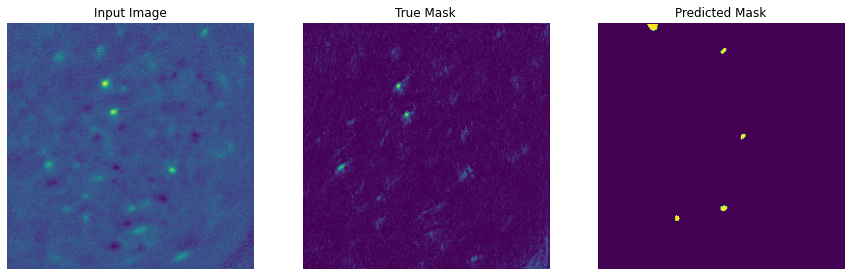

In [46]:
show_prediction(validation_dataset, 0)

In [14]:
a = (1,2,3)
a[:2]

(1, 2)

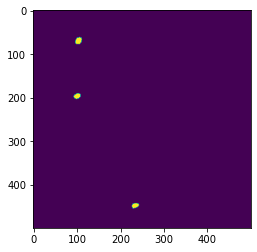

In [14]:
gt = gen.get_y(10)
plt.imshow(gt.reshape(500, 500))


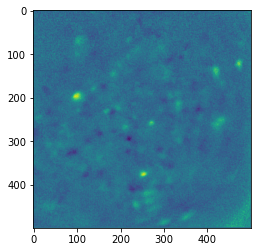

In [15]:
plt.imshow(gen.movie[10])

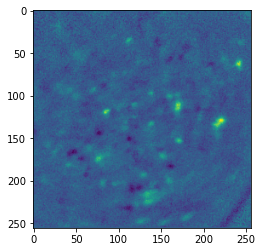

In [22]:
f = gen.movie[0]

f = skimage.transform.resize(f, FRAME_NEW_SHAPE, anti_aliasing=True)
plt.imshow(f)


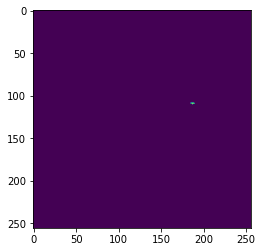

In [24]:
f = gen.filters_binary[0]
f = skimage.transform.resize(f, FRAME_NEW_SHAPE)
plt.imshow(f)

Lossy conversion from float32 to uint8. Range [-0.03215230628848076, 0.06589406728744507]. Convert image to uint8 prior to saving to suppress this warning.


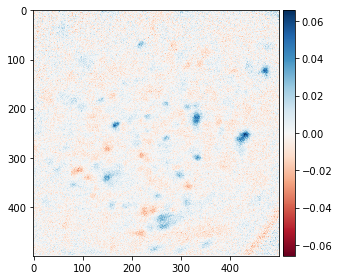

In [28]:
x = movie[0]
imshow(x)

imsave('frame0.png', x)